# Lab 4

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget
# %matplotlib inline

DATAFILE = "data/BetaFilter_data_in.dat"
df = pd.read_csv(DATAFILE, sep=" ")
t = df["time"].to_numpy()
y = df["position"].to_numpy()
u = np.zeros(len(y))
Ts = t[1] - t[0]

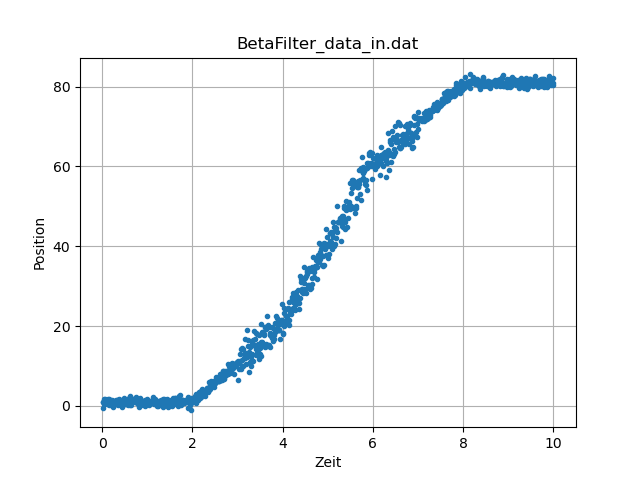

In [115]:
plt.figure()
plt.title("BetaFilter_data_in.dat")
plt.xlabel("Zeit")
plt.ylabel("Position")
plt.grid(True)
plt.plot(t, y, ".")
plt.show()


In [116]:
stable_s = y[t < 2]  # stable range from 0-2 and 8-* see plot above
# R = stable_s[~np.isnan(stable_s)].var()
R = stable_s.var()
Q = R / 100
print(f"{R=:g}")
print(f"{Q[0]=:g}")


R=0.389682
Q[0]=0.00389682


### Beta-Filter

$$
\boldsymbol{x}(k + 1) = \begin{bmatrix}
1 & T_s \\
0 & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(k) \\
v(k)
\end{bmatrix} + \begin{bmatrix}
0 \\
0 \\
\end{bmatrix} \cdot \boldsymbol{u}(k) + \begin{bmatrix}
T_s \\
1 \\
\end{bmatrix} \cdot \boldsymbol{z}(k)
$$

$$
\boldsymbol{y}(k) = s(t) = \begin{bmatrix}
1 & 0 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(t) \\
v(t) \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\end{bmatrix} \cdot u(k)
$$


In [117]:
# Define system matrices
Ad = np.array(
    [
        [1, Ts],
        [0, 1],
    ]
)
Bd = np.array(
    [
        [0],
        [0],
    ]
)
C = np.array([1, 0])
D = np.array([0])
Gd = np.array(
    [
        [Ts],
        [1],
    ]
)

# Initialization
x_dach = np.array([[y[0]], [0]])  # estimate
P_dach = 30 * np.eye(Bd.size)

s = np.zeros(len(y))  # prediction output array
v = np.zeros(len(y))  # variation
d_y = np.zeros(len(y))  # new error
y_dach = np.zeros(len(y))  # error

P_tilde0 = np.zeros(len(y))
P_tilde1 = np.zeros(len(y))
P_tilde2 = np.zeros(len(y))
P_tilde3 = np.zeros(len(y))


In [118]:
for i, y_i in enumerate(y):
    y_dach[i] = C @ x_dach + D * u[i]
    d_y[i] = y_i - y_dach[i]
    # K = P_dach @ C.reshape(-1,1) * (C @ P_dach @ C.reshape(-1,1) + R) ** (-1) # previous method
    k = C @ P_dach @ C.reshape(-1, 1) + R
    if k.ndim >= 2:
        K = (
            P_dach @ C.reshape(-1, 1) @ np.linalg.pinv(k)
        )  # penrose inverse works with k dimension greater 2
    else:
        K = P_dach @ C.reshape(-1, 1) / k  # use plain inverse otherwise

    x_tilde = x_dach + K * d_y[i]
    P_tilde = (np.eye(Bd.size) - K * C) @ P_dach
    # print(P_tilde)

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + (Gd * Q) @ Gd.T

    s[i], v[i] = x_tilde

    P_tilde0 = P_tilde[0][0]
    P_tilde1 = P_tilde[0][1]
    P_tilde2 = P_tilde[1][0]
    P_tilde3 = P_tilde[1][1]


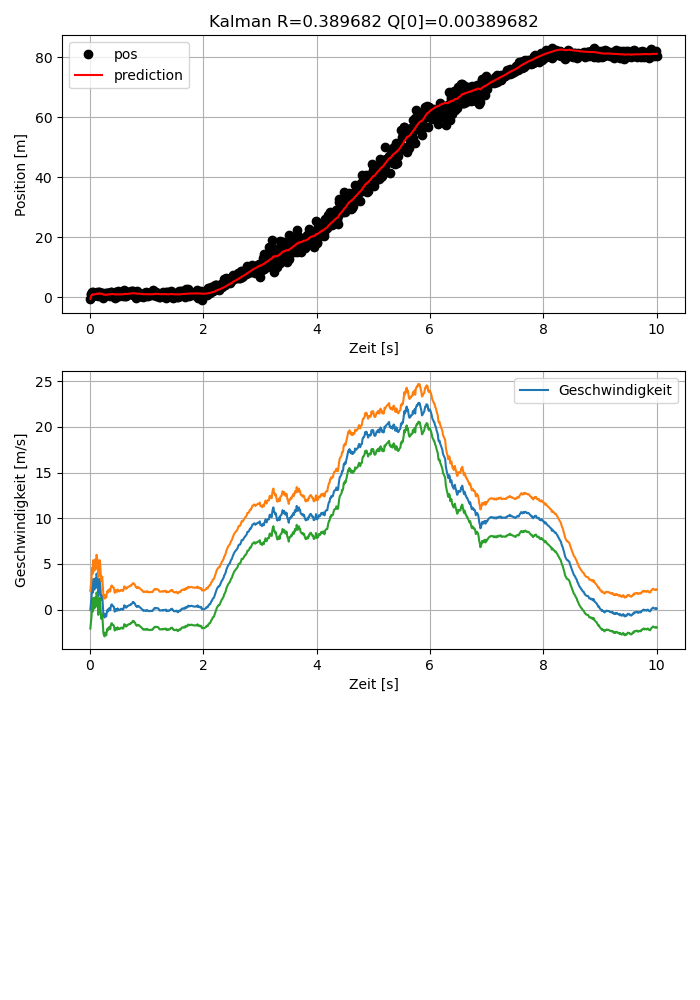

In [119]:
plt.figure(figsize=(7, 10))
plt.subplot(3, 1, 1)
plt.title(f"Kalman {R=:g} {Q[0]=:g}")
plt.xlabel("Zeit")
plt.grid(True)
plt.plot(t, y, "ko", label="pos")
plt.plot(t, s, "r-", label="prediction")
# plt.plot(t, s + 5 * np.sqrt(P_tilde0), "-")
# plt.plot(t, s - 5 * np.sqrt(P_tilde0), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Position [m]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, v, "-", label="Geschwindigkeit")
plt.plot(t, v + 5 * np.sqrt(P_tilde3), "-")
plt.plot(t, v - 5 * np.sqrt(P_tilde3), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Geschwindigkeit [m/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### ROSE-Filter

In [ ]:
stable_s = y[t < 2]  # stable range from 0-2 and 8-* see plot above
# R = stable_s[~np.isnan(stable_s)].var()
R = stable_s.var()
Q = R / 100
print(f"{R=:g}")
print(f"{Q[0]=:g}")

Gamma = 2.5
Alpha_R = 0.05
Alpha_M = 0.1
Q_min = R / 1000
Q_max = R / 10


In [131]:
# Vorabbestimmung K0 und H
R0 = 1
Q0 = 1
lmbda = Ts * np.sqrt(Q0 / R0)

K1 = (-1 / 8) * (lmbda**2 + 8 * lmbda - (lmbda + 4) * np.sqrt(lmbda**2 + 8 * lmbda))
K2 = 0.25 * (lmbda**2 + 4 * lmbda - lmbda * np.sqrt(lmbda**2 + 8 * lmbda)) / Ts

K0 = np.array([K1, K2])
H = (np.eye(len(Ad)) - K0 * C) * Ad

print(K0)


[0.13185099 0.93174514]


In [132]:
# Define system matrices
Ad = np.array(
    [
        [1, Ts],
        [0, 1],
    ]
)
Bd = np.array(
    [
        [0],
        [0],
    ]
)
C = np.array([1, 0])
D = np.array([0])
Gd = np.array(
    [
        [Ts],
        [1],
    ]
)

# Initialization
x_dach = np.array([[y[0]], [0]])  # estimate
P_dach = 1 * np.eye(Bd.size)
P_tilde = 1 * np.eye(Bd.size)

s = np.zeros(len(y))  # prediction output array
v = np.zeros(len(y))  # variation
d_y = np.zeros(len(y))  # new error
y_dach = np.zeros(len(y))  # error

P_tilde0 = np.zeros(len(y))
P_tilde1 = np.zeros(len(y))
P_tilde2 = np.zeros(len(y))
P_tilde3 = np.zeros(len(y))

GG = Gd @ Gd.T
M = C @ P_tilde @ C.T
x1 = x_dach

print(M)


1.0


In [ ]:
for i, y_i in enumerate(y):
    x1 = H @ x1 + K0 @ y_i
    yr[i] = x1[0]

    R = Gamma * Alpha_R * [y_i - x1[0]] * [y_i - x1[0]].T + (1 - Alpha_R) * R

    # -----------------------------------------------
    # Calculate Matrix M
    # -----------------------------------------------
    d_y[i] = y_i - C @ x_dach + D * u[i]
    M = Alpha_M * (d_y @ d_y.T) + (1 - Alpha_M) * M

    # -----------------------------------------------
    # Calculate P_dach
    # -----------------------------------------------
    Q[i] = Q
    Q_min if Q[i] < Q_min else Q[i]
    Q_max if Q[i] > Q_max else Q[i]
    P_dach = Ad @ P_tilde @ Ad.T + GG * Q[i]

    # -----------------------------------------------
    # kalman gain, correction of state x and P,
    # prediction of state x
    # -----------------------------------------------
    k = C @ P_dach @ C.reshape(-1, 1) + R
    if k.ndim >= 2:
        K = (
            P_dach @ C.reshape(-1, 1) @ np.linalg.pinv(k)
        )  # penrose inverse works with k dimension greater 2
    else:
        K = P_dach @ C.reshape(-1, 1) / k  # use plain inverse otherwise

    x_tilde = x_dach + K * d_y[i]
    P_tilde = (np.eye(Bd.size) - K * C) @ P_dach

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + (Gd * Q) @ Gd.T

    s[i], v[i] = x_tilde

    P_tilde0 = P_tilde[0][0]
    P_tilde1 = P_tilde[0][1]
    P_tilde2 = P_tilde[1][0]
    P_tilde3 = P_tilde[1][1]


In [ ]:
plt.figure(figsize=(7, 10))
plt.subplot(3, 1, 1)
plt.title(f"Kalman {R=:g} {Q[0]=:g}")
plt.xlabel("Zeit")
plt.grid(True)
plt.plot(t, y, "ko", label="pos")
plt.plot(t, s, "r-", label="prediction")
# plt.plot(t, s + 5 * np.sqrt(P_tilde0), "-")
# plt.plot(t, s - 5 * np.sqrt(P_tilde0), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Position [m]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, v, "-", label="Geschwindigkeit")
plt.plot(t, v + 5 * np.sqrt(P_tilde3), "-")
plt.plot(t, v - 5 * np.sqrt(P_tilde3), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Geschwindigkeit [m/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
